In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
from scipy.stats import norm
import sys
sys.path.append('../')
import imp
import pickle

In [7]:
import mdp
imp.reload(mdp)
from mdp import get_mdp, simulate_from_mdp

In [8]:
from rl_learner import TD_Learner
import torch
from mdp import get_reward_dist_per_state

## 4 level tree (9 states)

### Create MDP

In [117]:
P, R, n_states, states = get_mdp('9tree_mix')

9tree_mix


### Simulate

In [118]:
(states_all, rewards_all, 
 states_onehot_all, mask) = simulate_from_mdp(1, P, R, n_states, states, 
                                              n_episodes = 10_000, max_seq_len = 4)

In [11]:
ep = 0
print(states_all[ep,])
print(rewards_all[ep,])
print(states_onehot_all[ep,])

[ 0  1  4 -1]
[1.73591412]
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [12]:
ep = 10
print(states_all[ep,])
print(rewards_all[ep,])
print(states_onehot_all[ep,])

[ 0  1  4 -1]
[1.48098062]
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:
mask

array([[1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       ...,
       [1, 1, 1, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 0]])

### Plot Distribution

true thetas
[-2.49 -2.02 -1.57  1.57  2.31]


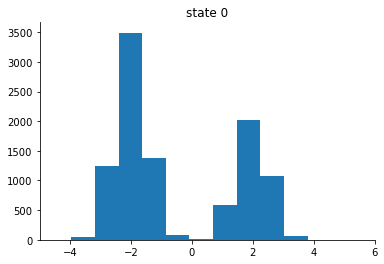

In [16]:
state = 0
rewards_per_state = get_reward_dist_per_state(state, states_all, rewards_all)
plt.hist(rewards_per_state)
plt.xlim([-5,6])
plt.title(f'state {state}')
sns.despine()

print('true thetas')
n_quantiles=5
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
thetas = [np.quantile(rewards_per_state.squeeze(), q) for q in taus]
print(np.array(thetas).round(2))


### Save 

In [17]:
# save out data 
print(states_onehot_all.shape)
print(rewards_all.shape)
np.save('../mscl/simple_mdp_mix_states_onehot.npy', states_onehot_all)
np.save('../mscl/simple_mdp_mix_rewards.npy', rewards_all)
np.save('../mscl/simple_mdp_mix_mask.npy', mask)

(10000, 4, 9)
(10000, 1)


### Train RL Batch Mode

`CUDA_VISIBLE_DEVICES=3 python train_rl_batch.py --epochs 50 --batch_size 40 --hidden_dim 100 --mdp_mode --n_quantiles 20 --target_every 100 --learning_rate 1e-4`

`CUDA_VISIBLE_DEVICES=3 python train_rl_batch.py --epochs 50 --batch_size 40 --linear --mdp_mode --n_quantiles 20 --target_every 100 --learning_rate 1e-3`

`CUDA_VISIBLE_DEVICES=3 python train_rl_batch.py --epochs 50 --batch_size 40 --linear --mdp_mode --n_quantiles 20 --target_every 100 --learning_rate 1e-3 --huber_k 0.1`

`CUDA_VISIBLE_DEVICES=3 python train_rl_batch.py --epochs 50 --batch_size 40 --hidden_dim 100 --mdp_mode --n_quantiles 20 --target_every 100 --learning_rate 1e-3 --huber_k 0.1`

### Look at Log

In [260]:
n_quantiles=20
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
taus

array([0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425,
       0.475, 0.525, 0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875,
       0.925, 0.975])

In [261]:
hidden_dim = 'linear'
hidden_dim = 100
epoch=45
huber_k = 0.1
file1 = f'../data/results/single_sentences_I_1/quantile_learner_mdp_{hidden_dim}/quantile_learner_mdp_epoch{epoch}.pkl'
file2=f'../data/results/single_sentences_I_1/quantile_learner_mdp_{hidden_dim}/log_quantile_learner_mdp_epoch{epoch}.pkl'

file1 = f'../data/results/single_sentences_I_1/quantile_learner_mdp_{hidden_dim}/quantile_learner_mdp_epoch{epoch}.pkl'
file2=f'../data/results/single_sentences_I_1/quantile_learner_mdp_{hidden_dim}/log_quantile_learner_mdp_epoch{epoch}.pkl'

file1 = f'../data/results/single_sentences_I_1/quantile_learner_mdp_{hidden_dim}_{huber_k}/quantile_learner_mdp_epoch{epoch}.pkl'
file2=f'../data/results/single_sentences_I_1/quantile_learner_mdp_{hidden_dim}_{huber_k}/log_quantile_learner_mdp_epoch{epoch}.pkl'


Z_network = TD_Learner(n_states, n_quantiles, hidden_dim=hidden_dim)
#Z_network = TD_Learner(n_states, n_quantiles, hidden_dim=None)

Z_network.load_state_dict(torch.load(file1, map_location=torch.device('cpu')))
log = pickle.load(open(file2,'rb'))

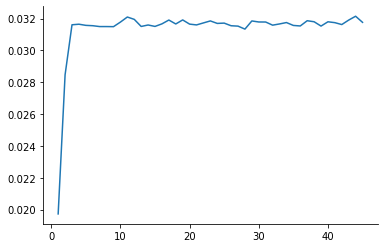

In [262]:
loss = np.array(log['loss'])
epoch = np.array(log['epoch'])
plt.plot(epoch, loss)
sns.despine()

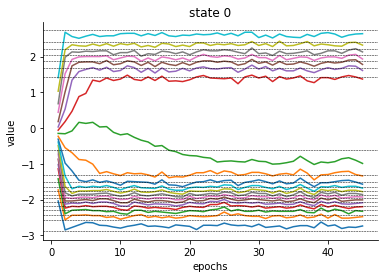

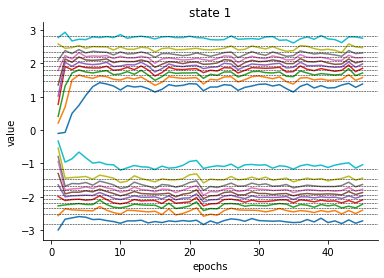

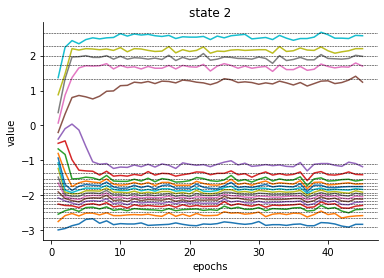

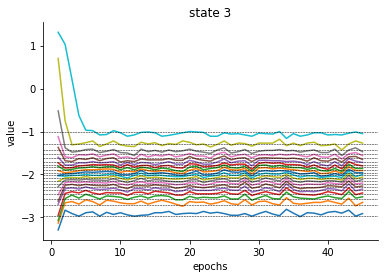

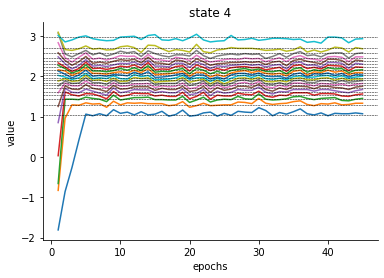

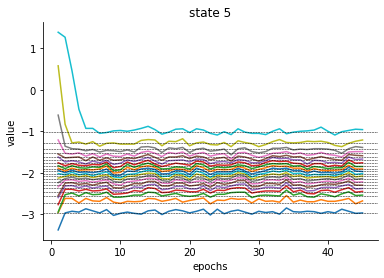

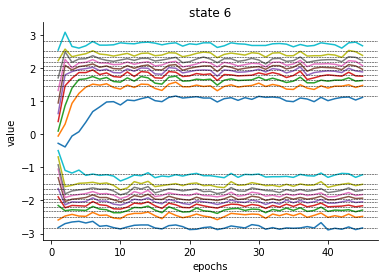

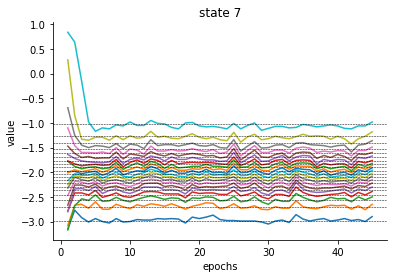

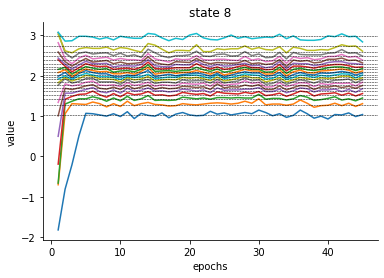

In [264]:
for state in range(9):
    theta_ests = np.array(log[f'state {state}'])
    plt.figure()
    plt.title(f'state {state}')
    plt.plot(epoch, theta_ests); 
    sns.despine()
    
    rewards_per_state = get_reward_dist_per_state(state, states_all, rewards_all)
    thetas = np.array([np.quantile(rewards_per_state.squeeze(), q) for q in taus]).round(2)
    for theta in thetas:
        plt.axhline(y=theta, linestyle='--', color='k', linewidth=0.5)
    plt.ylabel('value')
    plt.xlabel('epochs')
    

In [234]:
taus

array([0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425,
       0.475, 0.525, 0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875,
       0.925, 0.975])

### Estimate State 8 

In [215]:
from train_rl_batch import huber, append_to_log

In [ ]:
(states_all, rewards_all, 
 states_onehot_all, mask) = simulate_from_mdp(1, P, R, n_states, states, 
                                              n_episodes = 100_000, max_seq_len = 4)

In [219]:
state = 8
rewards_per_state = get_reward_dist_per_state(state, states_all, rewards_all)
print(len(rewards_per_state))
rewards_per_state

12377


array([[1.9137859 ],
       [1.56107079],
       [2.22376035],
       ...,
       [2.36862485],
       [0.74141603],
       [1.98459898]])

In [224]:
n_quantiles = 1
gamma = 1.0 
hidden_dim=None
state_dim = 9 
device='cpu'
Z_network = TD_Learner(state_dim, n_quantiles, hidden_dim).to(device)
Z_network_tgt = TD_Learner(state_dim, n_quantiles, hidden_dim).to(device)
tau = torch.Tensor((2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)).view(1, 1, -1).to(device) # third dimensional will be quantiles

# single quantile 
tau = torch.Tensor([[[0.05]]])

optimizer = torch.optim.Adam(params=Z_network.parameters(), lr=1e-3)


log_dict = {}
batch_size = 1
n_states = 9
for epoch in range(1, 3):
    print(epoch)
    epoch_loss = 0
    for idx in range(int(len(rewards_per_state)/batch_size)):
        
        rewards = rewards_per_state[idx][:,np.newaxis]
        #rewards = np.random.choice(rewards_per_state.flatten(), size=batch_size, replace=False)[:, np.newaxis]
        states = np.zeros((batch_size,n_states))
        states[:,state]=1
        
        optimizer.zero_grad()
        
        thetas = Z_network(torch.Tensor(states)).unsqueeze(1) # batchsize x 1 x n_qauntiles 
        reward_tensor = torch.zeros(thetas.shape).to(device)
        for i in range(reward_tensor.shape[0]):
            reward_tensor[i,0,:]=float(rewards[i])
        target_thetas = reward_tensor
        
        
        diff = target_thetas.view(-1, n_quantiles).t().unsqueeze(-1) - thetas.view(-1, n_quantiles)
        #loss = huber(diff) * (tau - (diff.detach() < 0).float()).abs()
        #loss = diff*(tau - (diff.detach() < 0).float())
        loss = huber(diff, 0.1) * (tau - (diff.detach() < 0).float()).abs()
        loss = loss.mean()
        loss.backward()
        optimizer.step()
    
        state_vec = np.zeros(state_dim)
        state_vec[state]=1
        with torch.no_grad():
            theta_hats = Z_network(torch.Tensor(state_vec).to(device)).detach().cpu().numpy().round(2)
        log_dict = append_to_log(log_dict, f'state {state}', theta_hats)
        #log_dict = append_to_log(log_dict, f'state {state}', thetas.detach().numpy())

1
2


In [225]:
diff

tensor([[[0.8026]]], grad_fn=<SubBackward0>)

In [226]:
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)

# single quantile 
taus = [0.05]

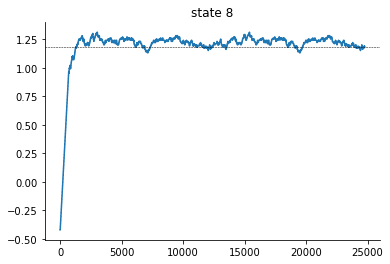

In [227]:
theta_ests = np.array(log_dict[f'state {state}'])
plt.figure()
plt.title(f'state {state}')
plt.plot(theta_ests); 
sns.despine()

rewards_per_state = get_reward_dist_per_state(state, states_all, rewards_all)
thetas = np.array([np.quantile(rewards_per_state.squeeze(), q) for q in taus]).round(2)
for theta in thetas:
    plt.axhline(y=theta, linestyle='--', color='k', linewidth=0.5)


In [228]:
print(np.mean(rewards_per_state<1.4))
print(np.mean(rewards_per_state<1.2))

0.1152137028359053
0.05372869031267674


### Look at Distributions and Compare to TD Learner

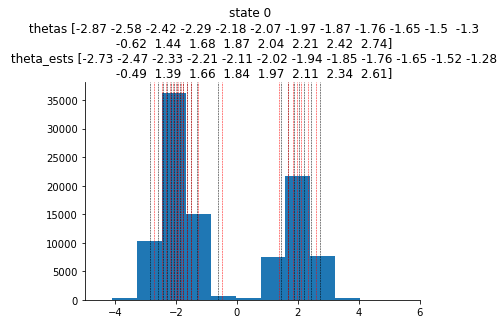

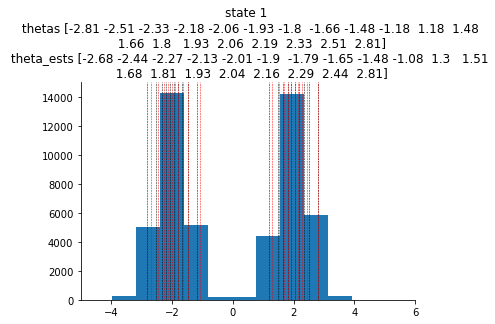

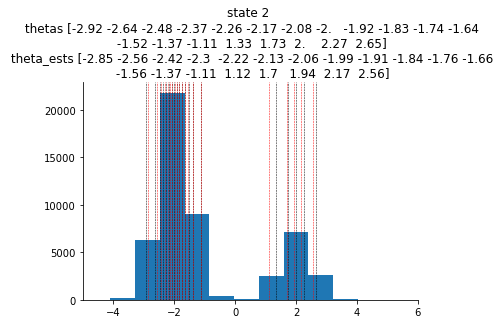

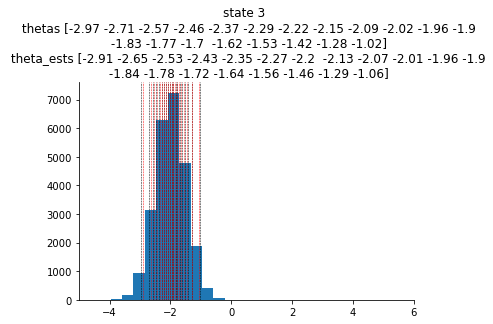

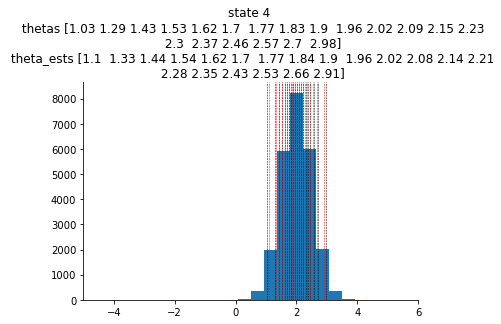

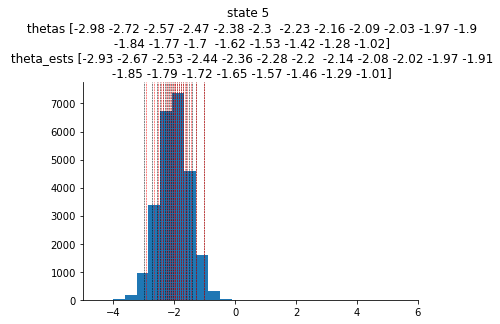

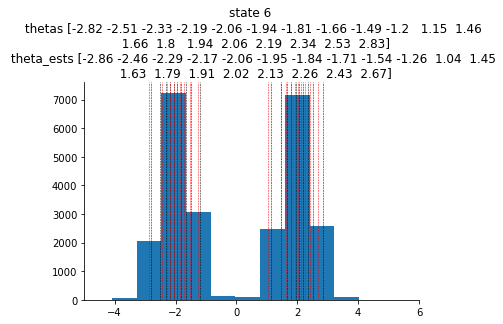

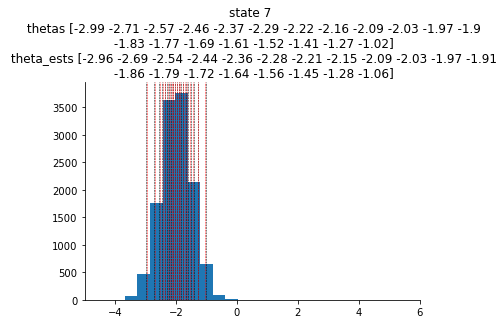

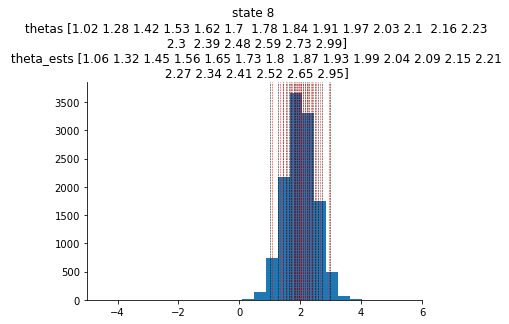

In [235]:
for state in range(9):
    
    rewards_per_state = get_reward_dist_per_state(state, states_all, rewards_all)
    
    # plot actual distribution 
    plt.figure()
    plt.title(f'state {state}')
    plt.hist(rewards_per_state)
    plt.xlim([-5,6])
    plt.title(f'state {state}')
    sns.despine()
    
    # print true thetas 
    #print('true thetas')
    thetas = np.array([np.quantile(rewards_per_state.squeeze(), q) for q in taus]).round(2)
    for theta in thetas:
        plt.axvline(x=theta, linestyle='--', color='k', linewidth=0.5)
    
    #print(np.array(thetas).round(2))
    
    # print estimates 
    #print('theta estimates')
    state_onehot = np.zeros(n_states)
    state_onehot[state]=1
    theta_ests = Z_network(torch.Tensor(state_onehot)).detach().cpu().numpy().round(2)
    for theta in theta_ests:
        plt.axvline(x=theta, linestyle='--', color='r', linewidth=0.5)
    
    plt.title(f'state {state} \n thetas {thetas}\n theta_ests {theta_ests}')

## Forward Sampling

In [239]:
import cvar_sampler
imp.reload(cvar_sampler)
from cvar_sampler import cvar_forward_sampler

### alpha 0.2

In [242]:
alpha0=0.2
s0=0
(states_all2, 
 rewards_all2, 
 alphas_all2) = cvar_forward_sampler(P, R, s0, alpha0, n_eps=100, 
                                     n_quantiles = 10, verbose = False,
                                     states_all_prev=states_all, rewards_all_prev=rewards_all,
                                     max_seq_len=4)


In [243]:
print(states_all2[0:5])
print(rewards_all2[0:5])

[[ 0  2  5 -1]
 [ 0  1  3 -1]
 [ 0  1  3 -1]
 [ 0  2  5 -1]
 [ 0  2  5 -1]]
[-2.14143178 -2.13316344 -2.52453387 -1.84167055 -2.59793076]


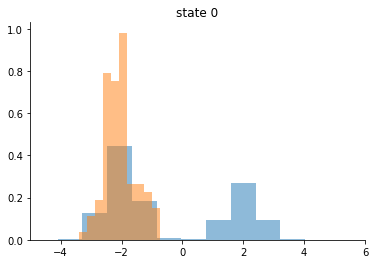

In [244]:
state = 0

plt.hist(get_reward_dist_per_state(state, states_all, rewards_all), alpha=0.5, density=True)
plt.hist(get_reward_dist_per_state(state, states_all2, rewards_all2), alpha=0.5, density=True)

plt.xlim([-5,6])
plt.title(f'state {state}')
sns.despine()

In [246]:
terminal_states = np.max(states_all2,axis=1)

In [249]:
(unique, counts) = np.unique(terminal_states, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[ 3, 40],
       [ 5, 42],
       [ 7, 18]])

### alpha 0.1

In [273]:
import cvar_sampler
imp.reload(cvar_sampler)
from cvar_sampler import cvar_forward_sampler
from cvar_helpers import calc_cvar_from_samples

In [325]:
alpha0=0.1
s0=0
(states_all2, 
 rewards_all2, 
 alphas_all2) = cvar_forward_sampler(P, R, s0, alpha0, n_eps=5000, 
                                     n_quantiles = 10, verbose = False,
                                     states_all_prev=states_all, rewards_all_prev=rewards_all,
                                     max_seq_len=4)


/home/cgagne/cvar_generation/conda_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [326]:
print(states_all2[0:5])
print(rewards_all2[0:5])

[[ 0  2  5 -1]
 [ 0  2  5 -1]
 [ 0  1  3 -1]
 [ 0  2  5 -1]
 [ 0  2  5 -1]]
[-3.52496484 -1.66582061 -2.09620715 -1.83358966 -1.31523825]


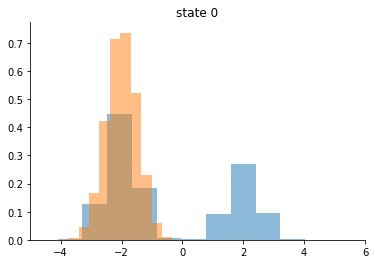

In [327]:
state = 0

plt.hist(get_reward_dist_per_state(state, states_all, rewards_all), alpha=0.5, density=True)
plt.hist(get_reward_dist_per_state(state, states_all2, rewards_all2), alpha=0.5, density=True)

plt.xlim([-5,6])
plt.title(f'state {state}')
sns.despine()

In [328]:
terminal_states = np.max(states_all,axis=1)

In [329]:
(unique, counts) = np.unique(terminal_states, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies = frequencies.astype('float')
frequencies[:,1]= frequencies[:,1]/frequencies[:,1].sum()
frequencies

array([[3.     , 0.24968],
       [4.     , 0.24952],
       [5.     , 0.25143],
       [7.     , 0.1256 ],
       [8.     , 0.12377]])

In [330]:
sort_idx = np.argsort(rewards_all.flatten(),axis=0)
rewards_all[sort_idx][0:int(len(rewards_all)*alpha0)]

array([[-4.09665552],
       [-4.02084022],
       [-3.96825147],
       ...,
       [-2.49254416],
       [-2.49250944],
       [-2.49248054]])

In [331]:
(unique, counts) = np.unique(terminal_states[sort_idx][0:int(len(rewards_all)*alpha0)], return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies = frequencies.astype('float')
frequencies[:,1]= frequencies[:,1]/frequencies[:,1].sum()
frequencies

array([[3.    , 0.3934],
       [5.    , 0.4072],
       [7.    , 0.1994]])

In [332]:
terminal_states = np.max(states_all2,axis=1)

In [333]:
(unique, counts) = np.unique(terminal_states, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies = frequencies.astype('float')
frequencies[:,1]= frequencies[:,1]/frequencies[:,1].sum()
frequencies

array([[3.    , 0.2524],
       [5.    , 0.6306],
       [7.    , 0.117 ]])

In [334]:
returns_cvar = get_reward_dist_per_state(state, states_all2, rewards_all2)
returns_all = get_reward_dist_per_state(state, states_all, rewards_all)

In [335]:
var, cvar = calc_cvar_from_samples(returns_all, alpha0)
print(cvar)
print(np.mean(returns_cvar))

[-2.75884592]
-1.9967638814809885
